# STEPN Minting cost calcurator

In [87]:
import requests
import json
import pandas as pd
from datetime import datetime

In [ ]:
#ref:https://tkstock.site/2018/06/12/post-402/
r = requests.get('https://api.coingecko.com/api/v3/coins/markets?vs_currency=jpy')
gecko = json.loads(r.text)
for status in gecko:
    print(status['name'] + ' ' + str(status['current_price']))

In [34]:
def get_btcprice(ticker, term): 
    url = ('https://api.coingecko.com/api/v3/coins/') + ticker + ('/market_chart?vs_currency=usd&days=') + term
    r = requests.get(url)
    r2 = json.loads(r.text) 
    return r2

In [54]:
#jsonから価格データだけをPandasに変換して抽出する
def get_price(r2):
    s = pd.DataFrame(r2['prices'])
    s.columns = ['date', 'price']
    date = []
    for i in s['date']:
        tsdate = int(i / 1000)
        loc = datetime.fromtimestamp(tsdate)
        date.append(loc)
    #s.index = date
    s["date"] = date
    #del s['date']
    return s

<ipython-input-260-378c813679b0>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-260-378c813679b0>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-260-378c813679b0>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-260-378c813679b0>:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

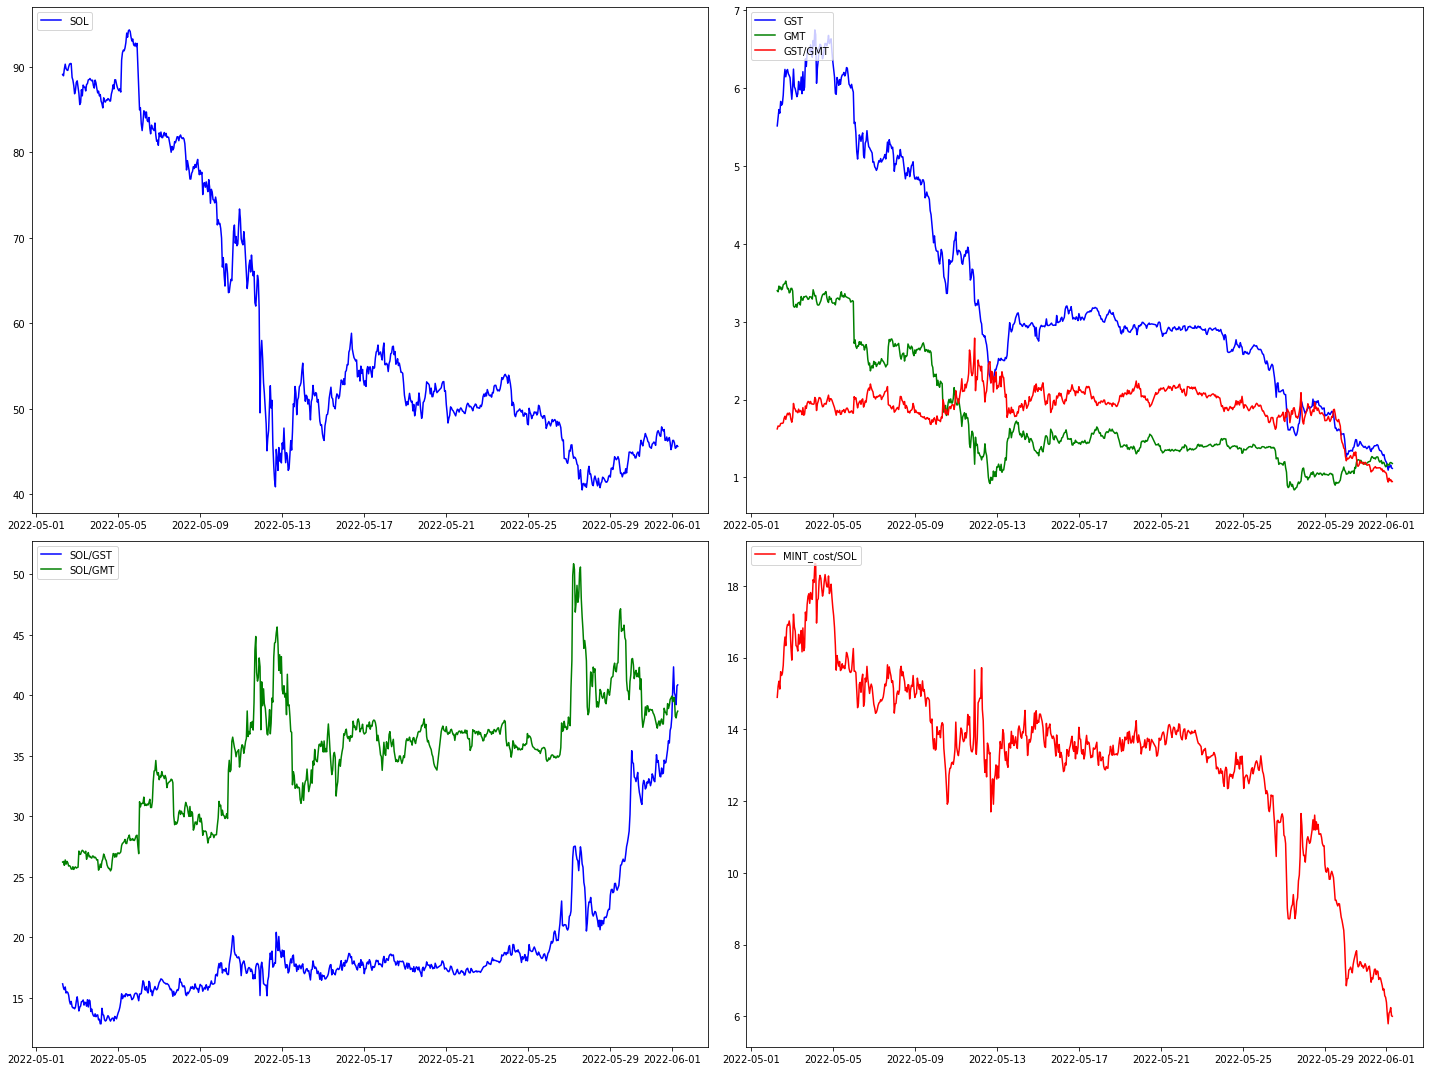

In [260]:
from datetime import datetime
term = "30"#recent 30 days data

r2=get_btcprice("solana", term)
sol = get_price(r2)
r3=get_btcprice("stepn", term)
gmt = get_price(r3)
r4=get_btcprice("green-satoshi-token", term)
gst = get_price(r4)

df = pd.merge(sol, gst, left_index=True, right_index=True)
df = pd.merge(df, gmt, left_index=True, right_index=True)
df = df.drop(["date", "date_y"], axis=1)
df = df.rename(columns={"date_x":"date", "price_x":"SOL", "price_y":"GST", "price":"GMT"})
df["SOL/GST"] = df["SOL"]/df["GST"]
df["SOL/GMT"] = df["SOL"]/df["GMT"]
df["GST/GMT"] = df["GST"]/df["GMT"]
df["MINT(200GST)"] = df["GST"]*200 + df["GST"]*20 + df["GMT"]*10
df["MINT(160GST+40GMT)"] = df["GST"]*160+df["GMT"]*40+ df["GST"]*20 + df["GMT"]*10
df["MINT(120GST+80GMT)"] = df["GST"]*120+df["GMT"]*80+ df["GST"]*20 + df["GMT"]*10
df["MINT(100GST+100GMT)"] = df["GST"]*100+df["GMT"]*100+ df["GST"]*20 + df["GMT"]*10
df["MINT(80GST+120GMT)"] = df["GST"]*80+df["GMT"]*120+ df["GST"]*20 + df["GMT"]*10
df["MINT(40GST+160GMT)"] = df["GST"]*40+df["GMT"]*160+ df["GST"]*20 + df["GMT"]*10
df["day"]=df["date"].dt.strftime("%Y/%m/%d")
df.index=df["date"]
del df["date"]


time_date = df.between_time("23:00:00", "23:59:59")
time_date["flag"]=None
for i in range(len(time_date)):
    if time_date["GST"][i] < 2:
        time_date["flag"][i] ="200GST"
    elif 2<=time_date["GST"][i]<3:
        time_date["flag"][i] ="160GST"
    elif 3<=time_date["GST"][i]<4:
        time_date["flag"][i] ="120GST"
    elif 4<=time_date["GST"][i]<8:
        time_date["flag"][i] ="100GST"
    elif 8<=time_date["GST"][i]<10:
        time_date["flag"][i] ="80GST"
    elif 10<=time_date["GST"][i]:
        time_date["flag"][i] ="40GST"

day = time_date["day"].to_list()
df["flag"]=None

for i in range(len(df)):
    for j in day:
        if df["day"][i] == j:
            df["flag"] = time_date[time_date["day"]== j]["flag"][0]

df["Dinamic_MINT_COST"]=None
for i in range(len(df)):
    if df["flag"][i] =="200GST":
        df["Dinamic_MINT_COST"][i]=df["MINT(200GST)"][i]
    elif df["flag"][i] == "160GST":
        df["Dinamic_MINT_COST"][i]=df["MINT(160GST+40GMT)"][i]
    elif df["flag"][i] == "120GST":
        df["Dinamic_MINT_COST"][i]=df["MINT(120GST+80GMT)"][i]
    elif df["flag"][i] == "100GST":
        df["Dinamic_MINT_COST"][i]=df["MINT(100GST+100GMT)"][i]
    elif df["flag"][i] == "80GST":
        df["Dinamic_MINT_COST"][i]=df["MINT(80GST+120GMT)"][i]
    elif df["flag"][i] =="40GST":
        df["Dinamic_MINT_COST"][i]=df["MINT(40GST+160GMT)"][i]

df["MINT_cost/SOL"] = df["Dinamic_MINT_COST"]/df["SOL"]/0.94

#ref:https://qiita.com/trami/items/bd54f22ee4449421f2bc
import matplotlib.pyplot as plt

#figure()でグラフを表示する領域をつくり，figというオブジェクトにする．
fig = plt.figure(figsize=(20, 15))

#add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

t = df.index.to_list()
y1 = df["SOL"].to_list()
y2 = df["GST"].to_list()
y3 = df["GMT"].to_list()
y4 = df["SOL/GST"].to_list()
y5 = df["SOL/GMT"].to_list()
y6 = df["GST/GMT"].to_list()
y7 = df["Dinamic_MINT_COST"].to_list()
y8 = df["MINT_cost/SOL"].to_list()

c1,c2,c3,c4 = "blue","green","red","black"      # 各プロットの色
l1,l2,l3= "SOL","GST","GMT"  # 各ラベル
l4,l5,l6= "SOL/GST","SOL/GMT","GST/GMT"  # 各ラベル
l7, l8= "Dinamic_MINT_COST","MINT_cost/SOL"  # 各ラベル

ax1.plot(t, y1, color=c1, label=l1)#SOL

ax2.plot(t, y2, color=c1, label=l2)#GST
ax2.plot(t, y3, color=c2, label=l3)#GMT
ax2.plot(t, y6, color=c3, label=l6)

ax3.plot(t, y4, color=c1, label=l4)
ax3.plot(t, y5, color=c2, label=l5)

ax4.plot(t, y8, color=c3, label=l8)
#ax4.plot(t, y1, color=c1, label=l1)

ax1.legend(loc = 'upper left') #凡例
ax2.legend(loc = 'upper left') #凡例
ax3.legend(loc = 'upper left') #凡例
ax4.legend(loc = 'upper left') #凡例
fig.tight_layout()              #レイアウトの設定
plt.show()

In [261]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
#fig = go.Figure()
fig = make_subplots(rows=2, cols=1)

fig.update_layout(title=dict(text='<b>Dynamic_MINT_Cost/SOL',
                             font=dict(size=26,
                                       color='grey'),
                             y=0.88,
                            ),
                  legend=dict(xanchor='left',
                              yanchor='bottom',
                              x=0.02,
                              y=0.85,
                              orientation='h'
                             )
                  )

fig.add_trace(go.Scatter(x=df.index,
                         y=df["MINT_cost/SOL"],
                         mode='lines',
                         name="MINT_cost/SOL",
                        ),row=1, col=1
              )

#SOL/GST,GMTのグラフ追加
fig.add_trace(go.Scatter(x=df.index,
                         y=df["SOL/GST"],
                         mode='lines',
                         name="SOL/GST",
                        ),row=2, col=1
              )

fig.add_trace(go.Scatter(x=df.index,
                         y=df["SOL/GMT"],
                         mode='lines',
                         name="SOL/GMT",
                        ),row=2, col=1
              )

fig.show()